# Caverns with constraints

In [26]:
import os

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar

from h2ss import data as rd
from h2ss import functions as fns

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Halite data

In [3]:
ds, extent = rd.kish_basin_data_depth_adjusted(
    dat_path=os.path.join("data", "kish-basin"),
    bathymetry_path=os.path.join("data", "bathymetry"),
)

In [4]:
xmin, ymin, xmax, ymax = extent.total_bounds

## Constraints

### Exploration wells

In [5]:
# 500 m buffer - suggested in draft OREDP II p. 108
wells, wells_b = fns.constraint_exploration_well(
    data_path=os.path.join(
        "data",
        "exploration-wells",
        "Exploration_Wells_Irish_Offshore.shapezip.zip",
    )
)

### Wind farms

In [6]:
# the shapes are used as is without a buffer - suggested for renewable energy
# test site areas in draft OREDP II p. 109
wind_farms = fns.constraint_wind_farm(
    data_path=os.path.join(
        "data", "wind-farms", "wind-farms-foreshore-process.zip"
    ),
    dat_extent=extent,
)

### Frequent shipping routes

In [7]:
# 1 NM (1,852 m) buffer - suggested in draft OREDP II p. 108
shipping, shipping_b = fns.constraint_shipping_routes(
    data_path=os.path.join(
        "data", "shipping", "shipping_frequently_used_routes.zip"
    ),
    dat_extent=extent,
)

### Shipwrecks

In [8]:
# Archaeological Exclusion Zones recommendation - 100 m buffer
shipwrecks, shipwrecks_b = fns.constraint_shipwrecks(
    data_path=os.path.join(
        "data", "shipwrecks", "IE_GSI_MI_Shipwrecks_IE_Waters_WGS84_LAT.zip"
    ),
    dat_extent=extent,
)

### Subsea cables

In [9]:
# 750 m buffer - suggested in draft OREDP II p. 109-111
cables, cables_b = fns.constraint_subsea_cables(
    data_path=os.path.join("data", "subsea-cables", "KIS-ORCA.gpkg")
)

### Distance from salt formation edge

In [10]:
edge_buffer = fns.constraint_halite_edge(dat_xr=ds)

## Zones of interest

In [11]:
# height = 85 m, 500 m <= depth <= 2,000 m, diameter = 80 m,
# separation = 320 m
zones, zds = fns.zones_of_interest(
    dat_xr=ds, constraints={"height": 85, "min_depth": 500, "max_depth": 2000}
)

## Generate caverns

### Exclude only shipping routes, wind farms, and cables

In [12]:
caverns, caverns_excl = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
    exclusions={"shipping": shipping_b, "edge": edge_buffer},
)

------------------------------------------------------------
Without constraints, excluding salt formation edges...
Number of potential caverns: 4,084
------------------------------------------------------------
Exclude shipping...
Number of potential caverns: 1,776
Caverns excluded: 56.51%
------------------------------------------------------------
Exclude wind farms...
No data specified!
------------------------------------------------------------
Exclude cables...
No data specified!
------------------------------------------------------------
Exclude wells...
No data specified!
------------------------------------------------------------
Exclude shipwrecks...
No data specified!
------------------------------------------------------------


In [13]:
caverns, caverns_excl = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
    exclusions={"cables": cables_b, "edge": edge_buffer},
)

------------------------------------------------------------
Without constraints, excluding salt formation edges...
Number of potential caverns: 4,084
------------------------------------------------------------
Exclude shipping...
No data specified!
------------------------------------------------------------
Exclude wind farms...
No data specified!
------------------------------------------------------------
Exclude cables...
Number of potential caverns: 3,889
Caverns excluded: 4.77%
------------------------------------------------------------
Exclude wells...
No data specified!
------------------------------------------------------------
Exclude shipwrecks...
No data specified!
------------------------------------------------------------


In [14]:
caverns, caverns_excl = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
    exclusions={"wind_farms": wind_farms, "edge": edge_buffer},
)

------------------------------------------------------------
Without constraints, excluding salt formation edges...
Number of potential caverns: 4,084
------------------------------------------------------------
Exclude shipping...
No data specified!
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 3,713
Caverns excluded: 9.08%
------------------------------------------------------------
Exclude cables...
No data specified!
------------------------------------------------------------
Exclude wells...
No data specified!
------------------------------------------------------------
Exclude shipwrecks...
No data specified!
------------------------------------------------------------


### Exclude all

In [15]:
caverns, caverns_excl = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

------------------------------------------------------------
Without constraints, excluding salt formation edges...
Number of potential caverns: 4,084
------------------------------------------------------------
Exclude shipping...
Number of potential caverns: 1,776
Caverns excluded: 56.51%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 1,416
Caverns excluded: 65.33%
------------------------------------------------------------
Exclude cables...
Number of potential caverns: 1,348
Caverns excluded: 66.99%
------------------------------------------------------------
Exclude wells...
Number of potential caverns: 1,348
Caverns excluded: 66.99%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 1,348
Caverns excluded: 66.99%
------------------------------------------------------------


In [16]:
caverns.describe()[["Thickness", "TopDepthSeabed"]]

,Thickness,TopDepthSeabed
count,1348.000000,1348.000000
mean,291.406212,1050.457546
std,82.368687,382.540338
min,175.062400,420.214316
25%,227.066775,725.721477
50%,272.752950,1012.201219
75%,341.484950,1323.807191
max,754.985800,1919.031682


In [17]:
# caverns in excluded areas
caverns_excl.describe()[["Thickness", "TopDepthSeabed"]]

,Thickness,TopDepthSeabed
count,2736.000000,2736.000000
mean,267.454312,958.949651
std,77.575979,321.398680
min,175.045900,420.589840
25%,216.175100,696.296484
50%,251.550700,969.251070
75%,294.237900,1189.993085
max,992.179400,1909.983075


In [18]:
# label caverns by height and depth
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[85, 155, 311],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

## Crop data layers

In [19]:
# land boundary
land = rd.read_shapefile_from_zip(
    data_path=os.path.join(
        "data", "boundaries", "osi-provinces-ungeneralised-2019.zip"
    )
)

land = land.dissolve().to_crs(rd.CRS)

In [20]:
# create exclusion buffer
buffer = pd.concat([wells_b, shipwrecks_b, shipping_b, cables_b]).dissolve()

In [21]:
# crop land areas from constraints and the buffer
# biospheres = biospheres.overlay(land, how="difference")
shipping = shipping.overlay(land, how="difference")
cables = cables.overlay(land, how="difference")
buffer = buffer.overlay(land, how="difference")

In [22]:
# # merge salt edge buffer
# buffer_edge = pd.concat(buffer_edge.values()).dissolve()

## Maps

In [37]:
def plot_map(dat_xr, fontsize=11.5):
    """Helper function to plot constraints and exclusions"""
    # initialise figure
    plt.figure(figsize=(10, 10))
    axis = plt.axes(projection=ccrs.epsg(rd.CRS))

    # halite boundary - use buffering to smooth the outline
    shape = rd.halite_shape(dat_xr=dat_xr).buffer(1000).buffer(-1000)

    # configure map limits
    plt.xlim(shape.bounds["minx"][0] - 10000, shape.bounds["maxx"][0] + 1500)
    plt.ylim(shape.bounds["miny"][0] - 1500, shape.bounds["maxy"][0] + 1500)

    # configure legend entries
    legend_handles = []

    shape.plot(ax=axis, zorder=1, linewidth=0, facecolor="white", alpha=0.35)
    shape.plot(
        ax=axis,
        edgecolor=sns.color_palette("flare", 4)[-2],
        color="none",
        linewidth=2,
        zorder=3,
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linewidth=2,
            label="Kish Basin boundary",
            edgecolor=sns.color_palette("flare", 4)[-2],
        )
    )

    # add constraint layers
    for df, color, label in zip(
        [buffer.overlay(wind_farms, how="difference"), wind_farms],
        ["slategrey", sns.color_palette("GnBu", 10)[-1]],
        ["Exclusion buffer", "Wind farm"],
    ):
        df.plot(
            ax=axis, facecolor="none", hatch="//", edgecolor=color, zorder=1
        )
        legend_handles.append(
            mpatches.Patch(
                facecolor="none", hatch="//", edgecolor=color, label=label
            )
        )

    for df, color, linewidth, label in zip(
        [cables, shipping],
        [sns.color_palette("GnBu", 10)[-4], sns.color_palette("flare", 4)[0]],
        [2, 3],
        ["Subsea cable", "Shipping route"],
    ):
        df.plot(ax=axis, color=color, linewidth=linewidth, zorder=2)
        legend_handles.append(
            Line2D([0], [0], color=color, label=label, linewidth=linewidth)
        )

    for df, marker, label in zip(
        [wells, shipwrecks], ["x", "+"], ["Exploration well", "Shipwreck"]
    ):
        df.plot(ax=axis, color="black", marker=marker, zorder=4)
        legend_handles.append(
            Line2D(
                [0],
                [0],
                marker=marker,
                linewidth=0,
                markeredgecolor="black",
                label=label,
            )
        )

    # add basemap and map elements
    cx.add_basemap(
        axis, crs=rd.CRS, source=cx.providers.CartoDB.Voyager, zoom=11
    )
    axis.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=0.25,
        color="darkslategrey",
        xformatter=LongitudeFormatter(auto_hide=False, dms=True),
        yformatter=LatitudeFormatter(auto_hide=False, dms=True),
        xlabel_style={"fontsize": fontsize},
        ylabel_style={"fontsize": fontsize, "rotation": 90},
    )
    axis.add_artist(
        ScaleBar(
            1,
            box_alpha=0,
            location="lower right",
            color="darkslategrey",
            font_properties={"size": fontsize},
        )
    )
    plt.legend(
        loc="lower right",
        bbox_to_anchor=(1, 0.05),
        handles=legend_handles,
        fontsize=fontsize,
    )
    plt.title(None)

    plt.tight_layout()
    plt.show()

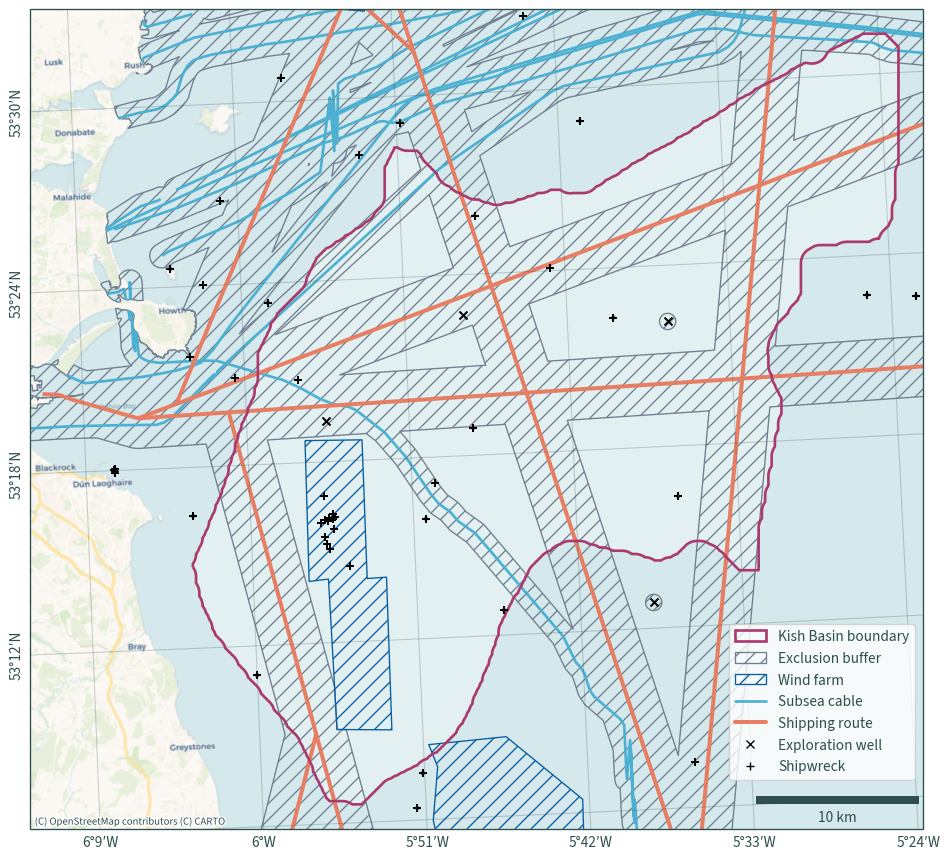

In [38]:
plot_map(ds)

In [41]:
def plot_map_alt(dat_xr, cavern_df, zones_gdf, fontsize=11.5):
    """Helper function to plot caverns within the zones of interest"""
    plt.figure(figsize=(20, 11.5))
    axis = plt.axes(projection=ccrs.epsg(rd.CRS))
    legend_handles = []

    # halite boundary - use buffering to smooth the outline
    shape = rd.halite_shape(dat_xr=dat_xr).buffer(1000).buffer(-1000)
    shape.plot(
        ax=axis,
        edgecolor="darkslategrey",
        color="none",
        linewidth=2,
        alpha=0.5,
        zorder=2,
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linewidth=2,
            edgecolor="darkslategrey",
            label="Kish Basin boundary",
            alpha=0.5,
        )
    )

    zones_gdf.plot(
        ax=axis, zorder=1, linewidth=0, facecolor="white", alpha=0.45
    )
    zones_gdf.plot(
        ax=axis,
        zorder=2,
        edgecolor="slategrey",
        linestyle="dotted",
        linewidth=1.25,
        facecolor="none",
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linestyle="dotted",
            edgecolor="slategrey",
            label="Area of interest",
            linewidth=1.25,
        )
    )

    pd.concat([buffer, wind_farms]).dissolve().clip(shape).plot(
        ax=axis,
        facecolor="none",
        linewidth=0.65,
        edgecolor="slategrey",
        zorder=2,
        alpha=0.5,
        hatch="//",
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            hatch="//",
            edgecolor="slategrey",
            label="Exclusion",
            alpha=0.65,
            linewidth=0.5,
        )
    )

    for df, markersize in zip(
        [
            cavern_df[cavern_df["depth"] == "500 - 1,000"],
            cavern_df[cavern_df["depth"] == "1,000 - 1,500"],
            cavern_df[cavern_df["depth"] == "1,500 - 2,000"],
        ],
        [20, 50, 20],
    ):
        gpd.GeoDataFrame(df, geometry=df.centroid).plot(
            ax=axis,
            column="Thickness",
            zorder=3,
            markersize=markersize,
            cmap="flare",
            linewidth=0,
            marker=".",
            scheme="UserDefined",
            classification_kwds={"bins": [155 + 90, 311 + 90]},
        )
    legend_handles.append(
        mpatches.Patch(label="Cavern height [m]", visible=False)
    )
    palette = [
        sns.color_palette("flare", 256)[0],
        sns.color_palette("flare", 256)[127],
        sns.color_palette("flare", 256)[-1],
    ]
    for color, label in zip(palette, ["85", "155", "311"]):
        legend_handles.append(mpatches.Patch(facecolor=color, label=label))
    legend_handles.append(
        mpatches.Patch(label="Cavern top depth [m]", visible=False)
    )
    for markersize, label in zip(
        [6, 3], ["1,000–1,500", "500–1,000 or \n1,500–2,000"]
    ):
        legend_handles.append(
            Line2D(
                [0],
                [0],
                marker=".",
                linewidth=0,
                label=label,
                color="darkslategrey",
                markersize=markersize,
            )
        )

    plt.xlim(shape.bounds["minx"][0] - 1000, shape.bounds["maxx"][0] + 1000)
    plt.ylim(shape.bounds["miny"][0] - 1000, shape.bounds["maxy"][0] + 1000)

    cx.add_basemap(
        axis, crs=rd.CRS, source=cx.providers.CartoDB.VoyagerNoLabels, zoom=12
    )
    axis.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=0.25,
        color="darkslategrey",
        xformatter=LongitudeFormatter(auto_hide=False, dms=True),
        yformatter=LatitudeFormatter(auto_hide=False, dms=True),
        xlabel_style={"fontsize": fontsize},
        ylabel_style={"fontsize": fontsize, "rotation": 90},
    )
    axis.add_artist(
        ScaleBar(
            1,
            box_alpha=0,
            location="lower right",
            color="darkslategrey",
            width_fraction=0.0075,
            font_properties={"size": fontsize},
        )
    )
    plt.legend(
        loc="lower right",
        bbox_to_anchor=(1, 0.05),
        handles=legend_handles,
        fontsize=fontsize,
    )

    plt.tight_layout()
    plt.show()

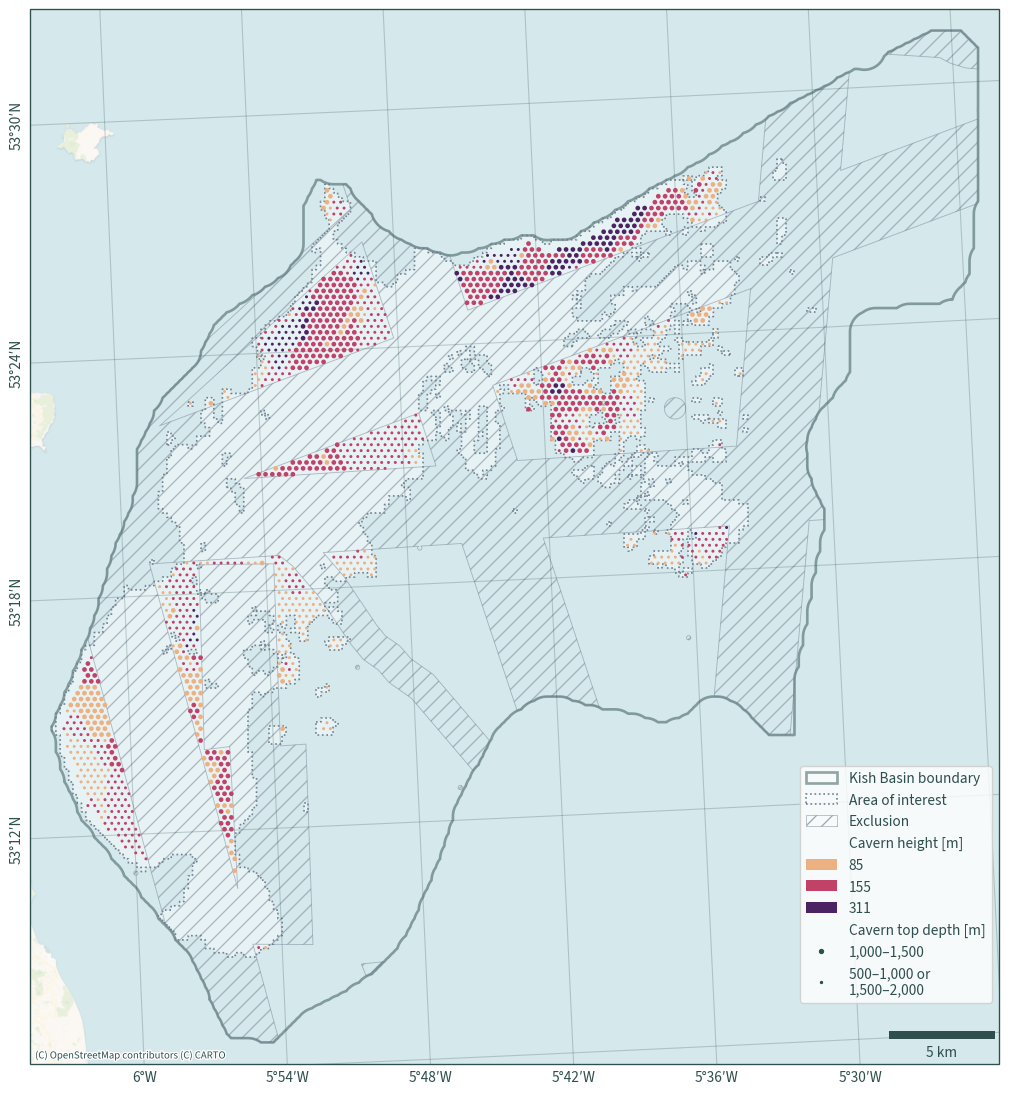

In [42]:
plot_map_alt(ds, caverns, zones)

## Stats

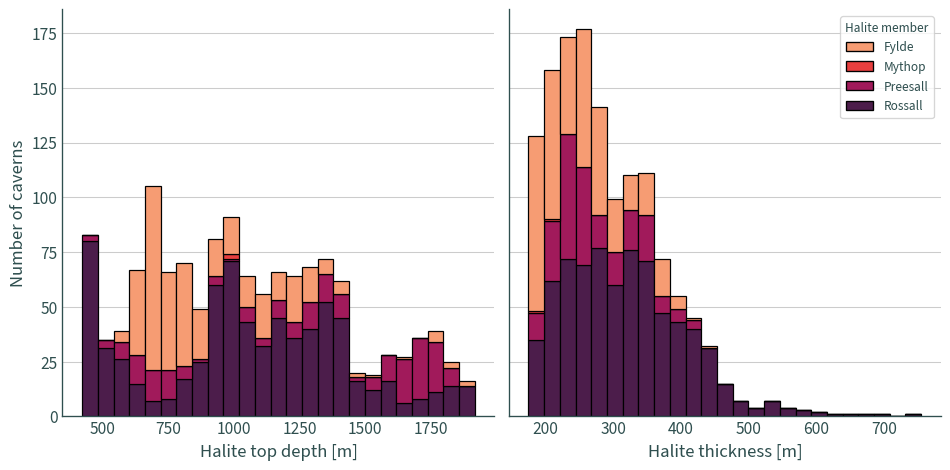

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.histplot(
    caverns.sort_values("halite"),
    x="TopDepthSeabed",
    palette="rocket_r",
    multiple="stack",
    hue="halite",
    alpha=1,
    bins=25,
    ax=axes[0],
    legend=False,
)
sns.histplot(
    caverns.sort_values("halite").rename(columns={"halite": "Halite member"}),
    x="Thickness",
    hue="Halite member",
    palette="rocket_r",
    multiple="stack",
    alpha=1,
    bins=25,
    ax=axes[1],
)
axes[0].set_xlabel("Halite top depth [m]")
axes[1].set_xlabel("Halite thickness [m]")
axes[0].grid(which="major", axis="y")
axes[1].grid(which="major", axis="y")
axes[0].set_ylabel("Number of caverns")
sns.despine()
plt.tight_layout()
plt.show()

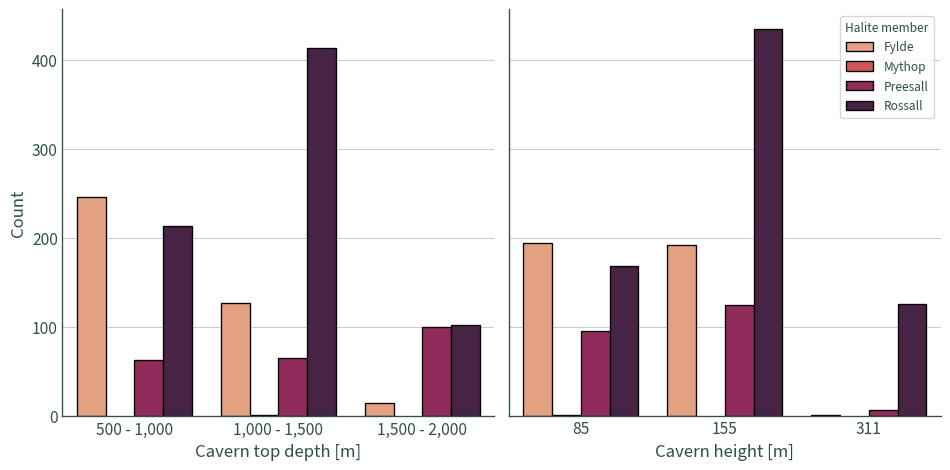

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.countplot(
    caverns.sort_values("halite"),
    ax=axes[0],
    x="depth",
    hue="halite",
    palette="rocket_r",
    legend=False,
    order=["500 - 1,000", "1,000 - 1,500", "1,500 - 2,000"],
    edgecolor="black",
)
axes[0].set_xlabel("Cavern top depth [m]")
sns.countplot(
    caverns.sort_values("halite"),
    ax=axes[1],
    x="height",
    hue="halite",
    palette="rocket_r",
    order=["85", "155", "311"],
    edgecolor="black",
)
axes[1].set_xlabel("Cavern height [m]")
axes[0].set_ylabel("Count")
axes[0].grid(which="major", axis="y")
axes[1].grid(which="major", axis="y")
plt.legend(title="Halite member")
sns.despine()
plt.tight_layout()
plt.show()

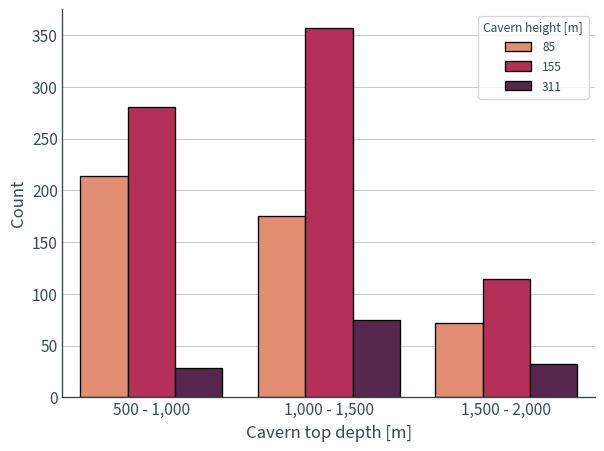

In [29]:
ax = sns.countplot(
    caverns.sort_values("Thickness"),
    x="depth",
    hue="height",
    palette="rocket_r",
    order=["500 - 1,000", "1,000 - 1,500", "1,500 - 2,000"],
    edgecolor="black",
)
ax.set_xlabel("Cavern top depth [m]")
ax.set_ylabel("Count")
ax.grid(which="major", axis="y")
sns.despine()
plt.legend(title="Cavern height [m]")
plt.tight_layout()
plt.show()

In [30]:
s = (
    caverns.sort_values("Thickness")
    .groupby("height", sort=False)
    .count()[["geometry"]]
)
s["%"] = s["geometry"] / len(caverns) * 100
s

,geometry,%
height,,
85,461,34.198813
155,752,55.786350
311,135,10.014837


In [31]:
s = (
    caverns.sort_values("TopDepthSeabed")
    .groupby("depth", sort=False)
    .count()[["geometry"]]
)
s["%"] = s["geometry"] / len(caverns) * 100
s

,geometry,%
depth,,
"500 - 1,000",523,38.798220
"1,000 - 1,500",607,45.029674
"1,500 - 2,000",218,16.172107


In [32]:
s = caverns.groupby(["height", "depth"], sort=False).count()[["geometry"]]
s["%"] = s["geometry"] / len(caverns) * 100
s

geometry          %
height depth                             
311    1,000 - 1,500        75   5.563798
155    1,000 - 1,500       357  26.483680
85     1,000 - 1,500       175  12.982196
311    500 - 1,000          28   2.077151
       1,500 - 2,000        32   2.373887
155    500 - 1,000         281  20.845697
       1,500 - 2,000       114   8.456973
85     1,500 - 2,000        72   5.341246
       500 - 1,000         214  15.875371

In [33]:
s = caverns.groupby("halite", sort=False).count()[["geometry"]]
s["%"] = s["geometry"] / len(caverns) * 100
s

,geometry,%
halite,,
Rossall,730,54.154303
Preesall,228,16.913947
Fylde,388,28.783383
Mythop,2,0.148368


In [34]:
s = caverns.groupby(["halite", "height"], sort=False).count()[["geometry"]]
s["%"] = s["geometry"] / len(caverns) * 100
s

geometry          %
halite   height                     
Rossall  311          126   9.347181
         155          435  32.270030
         85           169  12.537092
Preesall 155          125   9.272997
         85            96   7.121662
         311            7   0.519288
Fylde    311            2   0.148368
         155          192  14.243323
         85           194  14.391691
Mythop   85             2   0.148368

In [35]:
s = caverns.groupby(["halite", "depth"], sort=False).count()[["geometry"]]
s["%"] = s["geometry"] / len(caverns) * 100
s

geometry          %
halite   depth                             
Rossall  1,000 - 1,500       413  30.637982
         500 - 1,000         214  15.875371
         1,500 - 2,000       103   7.640950
Preesall 1,000 - 1,500        65   4.821958
         500 - 1,000          63   4.673591
         1,500 - 2,000       100   7.418398
Fylde    1,000 - 1,500       127   9.421365
         500 - 1,000         246  18.249258
         1,500 - 2,000        15   1.112760
Mythop   1,000 - 1,500         2   0.148368

In [36]:
s = caverns.groupby(["halite", "height", "depth"], sort=False).count()[
    ["geometry"]
]
s["%"] = s["geometry"] / len(caverns) * 100
s

geometry          %
halite   height depth                             
Rossall  311    1,000 - 1,500        73   5.415430
         155    1,000 - 1,500       269  19.955490
         85     1,000 - 1,500        71   5.267062
         311    500 - 1,000          21   1.557864
                1,500 - 2,000        32   2.373887
         155    500 - 1,000         114   8.456973
                1,500 - 2,000        52   3.857567
         85     1,500 - 2,000        19   1.409496
                500 - 1,000          79   5.860534
Preesall 155    1,000 - 1,500        24   1.780415
         85     1,000 - 1,500        41   3.041543
         311    500 - 1,000           7   0.519288
         155    500 - 1,000          46   3.412463
                1,500 - 2,000        55   4.080119
         85     1,500 - 2,000        45   3.338279
                500 - 1,000          10   0.741840
Fylde    311    1,000 - 1,500         2   0.148368
         155    1,000 - 1,500        64   4.747774
         85     1,000 - 1,500        61   4.525223
         155    500 - 1,000         121   8.976261
                1,500 - 2,000         7   0.519288
         85     500 - 1,000         125   9.272997
                1,500 - 2,000         8   0.593472
Mythop   85     1,000 - 1,500         2   0.148368